In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("ObesityDataSet.csv")
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        

In [4]:
# Map binary string features to numeric
binary_map = {'yes': 1, 'no': 0}
binary_features = ['FAVC','SMOKE','SCC','family_history_with_overweight']
for col in binary_features:
    df[col] = df[col].map(binary_map)

In [5]:
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

In [6]:
le = LabelEncoder()
y_encoded = le.fit_transform(y) 

In [7]:
# -------------------------
# Train/Test split (80/20)
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [8]:
# -------------------------
# Define feature types
# -------------------------
# Feature lists
numeric_features = ['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE']
categorical_features = ['Gender','CAEC','CALC','MTRANS']


In [9]:
# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'  # binary features remain as-is
)

X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

In [10]:
# -------------------------
# Create pipeline with Decision Tree
# -------------------------
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)


In [11]:
# -------------------------
# Train model
# -------------------------
dt_model.fit(X_train_pre, y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [12]:
# -------------------------
# Predict
# -------------------------
y_pred = dt_model.predict(X_test_pre)
y_prob = dt_model.predict_proba(X_test_pre)

In [13]:
# -------------------------
# Evaluation Metrics
# -------------------------
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)
auc = roc_auc_score(
    pd.get_dummies(y_test),  # one-vs-rest encoding
    y_prob,
    multi_class='ovr',
    average='weighted'
)

print("=== Decision Tree Evaluation Metrics ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MCC Score: {mcc:.4f}")


=== Decision Tree Evaluation Metrics ===
Accuracy: 0.9125
AUC Score: 0.9487
Precision: 0.9157
Recall: 0.9125
F1 Score: 0.9134
MCC Score: 0.8980


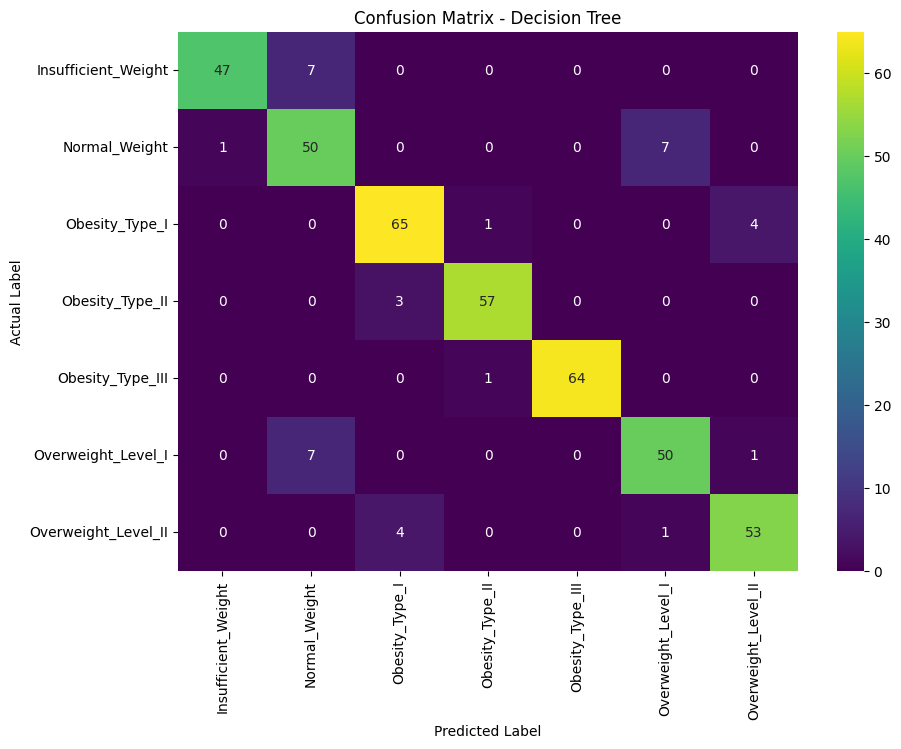

In [14]:
# -------------------------
# Optional: Confusion Matrix
# -------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

In [15]:
os.makedirs('model', exist_ok=True)

# Save preprocessor
joblib.dump(preprocessor, 'model/dt_preprocessor.pkl')

# Save trained Decision Tree
joblib.dump(dt_model, 'model/decision_tree_model.pkl')

print("✅ Decision Tree model and preprocessor saved successfully!")

✅ Decision Tree model and preprocessor saved successfully!
